# Atividade 2 - Etapa 2

In [1]:
#faça a importação do drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importação do dataset
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ECOM09A/Atividade02/dataset/articles.csv', encoding='utf8')
print('linhas, colunas):', df.shape)

df.head()

linhas, colunas): (167053, 6)


,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


### **Ajustes para aprendizado - já realizados na Etapa1_v02**

In [3]:
df.drop_duplicates(subset=['text'], inplace=True)
df.drop(['subcategory', 'link', 'date'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,title,text,category
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,poder
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",ilustrada
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,poder
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,ilustrada
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",mercado


In [4]:
df['category'].value_counts()

category
poder                           22005
colunas                         21499
mercado                         20936
esporte                         19723
mundo                           17123
cotidiano                       16952
ilustrada                       15604
opiniao                          4523
paineldoleitor                   4008
saopaulo                         3953
tec                              2205
educacao                         2113
tv                               2065
turismo                          1902
ilustrissima                     1377
ciencia                          1331
equilibrioesaude                 1311
sobretudo                        1052
bbc                               979
folhinha                          875
empreendedorsocial                841
comida                            828
asmais                            547
ambiente                          490
seminariosfolha                   378
serafina                          331
o-m

### **Utilizarei as 7 categorias mais relevantes no treinamento a fim de deixar o dataset mais balanceado**

In [5]:
df = df[df['category'].isin(list(df['category'].value_counts()[:7].index))]

df['category'] = df['category'].replace('guia-de-livros-discos-filmes', 'guia-de-livros-filmes-discos')
alvo, valores = pd.factorize(df['category'], sort=True)
df['target'] = alvo
print('Novo tamanho do dataset:', len(df))
list(enumerate(valores))

Novo tamanho do dataset: 133842


<ipython-input-5-59e17afd0b1d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = df['category'].replace('guia-de-livros-discos-filmes', 'guia-de-livros-filmes-discos')
<ipython-input-5-59e17afd0b1d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = alvo


[(0, 'colunas'),
 (1, 'cotidiano'),
 (2, 'esporte'),
 (3, 'ilustrada'),
 (4, 'mercado'),
 (5, 'mundo'),
 (6, 'poder')]

In [6]:
import nltk
import tensorflow as tf
import re, string, unicodedata
import matplotlib.pyplot as plt

from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud,STOPWORDS

#instalação do modelo 'stopwords'
nltk.download('stopwords')

from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing import text, sequence
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **Remoção de Palavras Irrelevantes (Stopwords)**

Não acrescentam muito a sentença e podem ser facilmente ignoradas sem sacrificar o significado do texto.

In [7]:
stop = set(stopwords.words('portuguese'))
punctuation = list(string.punctuation)
stop.update(punctuation)

### **Limpeza de Texto**

In [8]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    #text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
df['text']=df['text'].apply(denoise_text)

**WORDCLOUD**

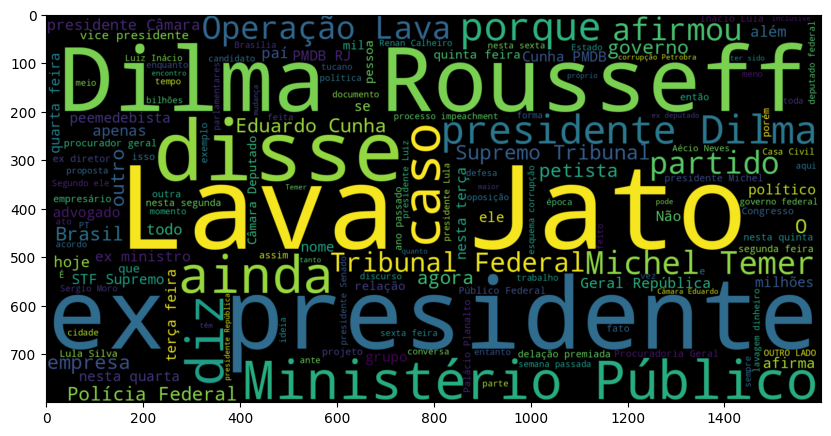

In [32]:
# criação de uma nuvem de palavras para textos da categoria 'poder'
plt.figure(figsize = (10, 10)) # Text that is Not Sarcastic
wc = WordCloud(max_words=150, width=1600 , height=800).generate(" ".join(df[df.category == 'poder'].text))
plt.imshow(wc , interpolation = 'bilinear')

### **Introdução à incorporação de palavras e Word2Vec**

Representação do vocabulário de documentos. É capaz de de capturar o contexto de uma palavra em um documento, semelhança semântica e sintática, relação com outras palavras.

Incorporação de palavras: representações vetoriais de uma palavra específica. Word2Vec é uma técnica para aprender incorporações de palavras usando rede neural superficial.

**Convertendo para um formato aceitado pela biblioteca _gensim_**

In [10]:
words = []
for i in df.text.values:
    # se não for string, converte para string
    if not isinstance(i, str):
        i = str(i)
    words.append(i.split())

words[:2]

[['possibilidade',
  'condenação',
  'impedir',
  'candidatura',
  '2018,',
  'ex-presidente',
  'Luiz',
  'Inácio',
  'Lula',
  'Silva',
  'fez,',
  'nesta',
  'segunda',
  '(9),',
  'discurso',
  'inflamado',
  'contra',
  'Lava',
  'Jato,',
  'disse',
  'saber',
  '"lascado",',
  'exigiu',
  'pedido',
  'desculpas',
  'juiz',
  'Sergio',
  'Moro',
  'afirmou',
  'que,',
  'disputa',
  'Planalto,',
  'cabo',
  'eleitoral',
  'expressivo',
  'sucessão',
  'Michel',
  'Temer.',
  'Segundo',
  'petista,',
  'réu',
  'sete',
  'ações',
  'penais,',
  'objetivo',
  'Moro',
  'impedir',
  'candidatura',
  'ano',
  'vem,',
  'desidratando-o,',
  'inclusive,',
  'apoio',
  'nome',
  'alternativo,',
  'ex-prefeito',
  'Paulo',
  'Fernando',
  'Haddad',
  '(PT),',
  'caso',
  'possa',
  'concorrer',
  'Presidência.',
  '"Eu',
  'sei',
  'tô',
  'lascado,',
  'todo',
  'dia',
  'processo.',
  'quero',
  'Moro',
  'absolva,',
  'quero',
  'peça',
  'desculpas",',
  'disse',
  'Lula',
  'durante'

In [11]:
import gensim
# dimensão do vetor a ser gerado
EMBEDDING_DIM = 100
# criando um vetor de palavras através do Método Word2Vec
w2v_model = gensim.models.Word2Vec(sentences=words, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [12]:
len(w2v_model.wv.key_to_index)

1100485

In [13]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train , maxlen=20)

In [14]:
# index 0 é reservado, portanto adicionamos 1
vocab_size = len(tokenizer.word_index) + 1
print('Tamanho do vocabulário:', vocab_size)

Tamanho do vocabulário: 976635


In [25]:
import numpy as np

def get_weight_matrix(model, vocab):
    # tamanho total do vocabulário para palavras desconhecidas
    vocab_size = len(vocab) + 1

    # definindo a dimensão da matriz de pesos inicializada com 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

    # armazena vetores usando o mapeamento inteiro do Tokenizer
    for word, i in vocab.items():
        if word in model.wv:

            weight_matrix[i] = model.wv[word]

    return weight_matrix

embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [16]:
print("Tamanho do vocabulário:", vocab_size)
print("Shape dos embedding_vectors:", embedding_vectors.shape)

Tamanho do vocabulário: 976635
Shape dos embedding_vectors: (976635, 100)


### **Treinando o modelo Word2Vec**

In [26]:
#entradas = len(vocab_size)
saidas = len(valores)

# modelo de rede neural
model = tf.keras.models.Sequential([
    # non trainable embedding layer
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], trainable=True, input_length=20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, recurrent_dropout=0.3, dropout=0.3, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=32, recurrent_dropout=0.1, dropout=0.1)),
    tf.keras.layers.Dense(saidas, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['acc'])
del embedding_vectors

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           97663500  
                                                                 
 bidirectional_2 (Bidirecti  (None, 20, 256)           234496    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                55680     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 97954131 (373.67 MB)
Trainable params: 97954131 (373.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**A função pd.get_dummies() é utilizada para converter variáveis categóricas em indicadoras, haja vista que, para algoritmos de aprendizado de máquina, as entradas devem ser numéricas.**

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, pd.get_dummies(df['target']).values, test_size = 0.3, random_state = 0)

In [30]:
history = model.fit(x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=3)

Epoch 1/3
732/732 [==============================] - 250s 318ms/step - loss: 0.1841 - acc: 0.7413 - val_loss: 0.1576 - val_acc: 0.7837
Epoch 2/3
732/732 [==============================] - 229s 313ms/step - loss: 0.1329 - acc: 0.8242 - val_loss: 0.1640 - val_acc: 0.7760
Epoch 3/3
732/732 [==============================] - 218s 298ms/step - loss: 0.1126 - acc: 0.8563 - val_loss: 0.1835 - val_acc: 0.7635


In [31]:
print("Accuracy of the model on Training Data is - ", model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

2928/2928 [==============================] - 74s 25ms/step - loss: 0.0829 - acc: 0.9025
Accuracy of the model on Training Data is -  90.24859070777893
1255/1255 [==============================] - 32s 26ms/step - loss: 0.1835 - acc: 0.7635
Accuracy of the model on Testing Data is -  76.35294795036316
